# 100 is the goal !

Import all the necessary libraries.

In [29]:
import numpy as np
import tensorflow as tf
from tensorflow import keras
import matplotlib.pyplot as plt
from sklearn.datasets import fetch_openml
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelBinarizer

### Load the MNIST dataset 

In [30]:
mnist = fetch_openml('mnist_784', version=1)
x, y = mnist.data / 255.0, mnist.target.astype(int)
y = LabelBinarizer().fit_transform(y)  # One-hot encoding des labels

### Separation into training and testing

In [31]:
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=42)

### Model creation

In [32]:
# model = keras.Sequential([
#     keras.layers.Dense(512, activation='relu', input_shape=(784,)),
#     keras.layers.Dense(256, activation='relu'),
#     keras.layers.Dense(128, activation='relu'),
#     keras.layers.Dense(64, activation='relu'),
#     keras.layers.Dense(32, activation='relu'),
#     keras.layers.Dense(10, activation='softmax')
# ])

model = keras.Sequential([
    keras.layers.Conv2D(32, (3,3), activation='relu', input_shape=(28,28,1)),
    keras.layers.MaxPooling2D(2,2),
    keras.layers.Conv2D(64, (3,3), activation='relu'),
    keras.layers.MaxPooling2D(2,2),
    keras.layers.Flatten(),
    keras.layers.Dense(128, activation='relu'),
    keras.layers.Dense(10, activation='softmax')
])


/home/mathieu/code/mnist/.venv/lib/python3.10/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


### Model compilation with reduced learning rate

In [33]:
model.compile(optimizer=keras.optimizers.Adam(learning_rate=0.0001), loss='categorical_crossentropy', metrics=['accuracy'])

### Callback to save the best weights and stop at 100%.

In [34]:
checkpoint = keras.callbacks.ModelCheckpoint('best_model.keras', monitor='val_accuracy', save_best_only=True, mode='max')
early_stopping = keras.callbacks.EarlyStopping(monitor='val_accuracy', patience=5, verbose=1, restore_best_weights=True)

class StopAt100Accuracy(tf.keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs=None):
        if logs.get('accuracy') == 1.0:
            print("\n100% accuracy atteint, arrêt de l'entraînement.")
            self.model.stop_training = True

Reshape the data for Conv2D

In [35]:
x_train = np.array(x_train)
x_test = np.array(x_test)

x_train = x_train.reshape(-1, 28, 28, 1)
x_test = x_test.reshape(-1, 28, 28, 1)

x_train = x_train.astype('float32') / 255.0
x_test = x_test.astype('float32') / 255.0

### Model training with lots of epochs and a smaller batch size 

In [36]:
history = model.fit(x_train, y_train, epochs=60, batch_size=16, verbose=1, validation_data=(x_test, y_test), callbacks=[checkpoint, early_stopping, StopAt100Accuracy()])

Epoch 1/60
3500/3500 ━━━━━━━━━━━━━━━━━━━━ 28s 8ms/step - accuracy: 0.5182 - loss: 1.5679 - val_accuracy: 0.8629 - val_loss: 0.4596
Epoch 2/60
3500/3500 ━━━━━━━━━━━━━━━━━━━━ 25s 7ms/step - accuracy: 0.8736 - loss: 0.4220 - val_accuracy: 0.8987 - val_loss: 0.3430
Epoch 3/60
3500/3500 ━━━━━━━━━━━━━━━━━━━━ 25s 7ms/step - accuracy: 0.9033 - loss: 0.3246 - val_accuracy: 0.9129 - val_loss: 0.2797
Epoch 4/60
3500/3500 ━━━━━━━━━━━━━━━━━━━━ 25s 7ms/step - accuracy: 0.9225 - loss: 0.2612 - val_accuracy: 0.9326 - val_loss: 0.2229
Epoch 5/60
3500/3500 ━━━━━━━━━━━━━━━━━━━━ 25s 7ms/step - accuracy: 0.9384 - loss: 0.2062 - val_accuracy: 0.9459 - val_loss: 0.1868
Epoch 6/60
3500/3500 ━━━━━━━━━━━━━━━━━━━━ 25s 7ms/step - accuracy: 0.9476 - loss: 0.1733 - val_accuracy: 0.9506 - val_loss: 0.1650
Epoch 7/60
3500/3500 ━━━━━━━━━━━━━━━━━━━━ 26s 7ms/step - accuracy: 0.9582 - loss: 0.1400 - val_accuracy: 0.9586 - val_loss: 0.1433
Epoch 8/60
3500/3500 ━━━━━━━━━━━━━━━━━━━━ 26s 7ms/step - accuracy: 0.9626 - loss: 0

### Loading the best weights

In [37]:
model.load_weights('best_model.keras')

### Evaluation


In [38]:
loss, accuracy = model.evaluate(x_test, y_test)
print(f'Accuracy sur le test set : {accuracy * 100:.2f}%')

438/438 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.9847 - loss: 0.0501
Accuracy sur le test set : 98.50%


### Display of learning curves

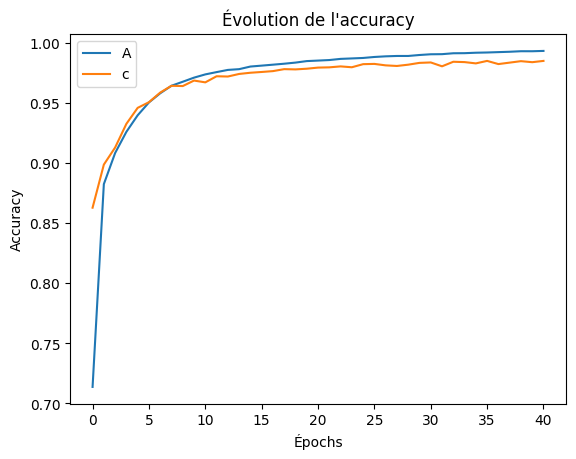

In [39]:
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Épochs')
plt.ylabel('Accuracy')
plt.legend("Accuracy")
plt.title('Évolution de l\'accuracy')
plt.show()
